In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# натсроить размер графика по умолчанию
sns.set(rc={"figure.figsize": (9, 8)})

# Дополнительно: Во всех заданиях (кроме расчета среднего чека) можно пренебречь товарами, которые указаны в orders, но отсутствуют в products.

In [69]:
# 1. Загрузка и просмотр данных
df_orders = pd.read_excel('orders.xlsx')
df_products = pd.read_excel('products.xlsx')

In [3]:
df_orders.head(2)

,order_id,accepted_at,product_id,quantity,regular_price,price,cost_price
0,1517514900,2022-01-13 16:48:19,17122,1,169,169,74
1,1517430051,2022-01-13 16:46:53,17122,1,169,169,74


In [4]:
df_products.head(2)

,product_id,level1,level2,name
0,1,Гигиена,Бритье,Кассеты для бритья Gillette Fusion ProGlide Po...
1,2,Мучные кондитерские изделия,Мучные кондитерские изделия,Печенье Бодрость


Предобработка данных

In [ ]:
# 2. Объеденить данные
merge_df = pd.merge(df_orders, df_products, on='product_id', how='left')

# 3. Добавить поле с датой для последующей фильтрации
merge_df['date'] = pd.to_datetime(merge_df['accepted_at']).dt.strftime('%Y-%m-%d')

# 4. Дополнить df расчетом стоимости продажи позиции в чеке
merge_df['total_sel_price'] = merge_df['price'] * merge_df['quantity']

# 5. Дополнить df расчетом себестоимости позиции в чеке
merge_df['total_cost_price'] = merge_df['cost_price'] * merge_df['quantity']

# 6. Добавить метку "продажа с дисконтом 'да/нет'"
merge_df['discont'] = np.where(merge_df['regular_price'] != merge_df['price'], True, False)

merge_df.head(2)

,order_id,accepted_at,product_id,quantity,regular_price,price,cost_price,level1,level2,name,date,total_sel_price,total_cost_price,discont
0,1517514900,2022-01-13 16:48:19,17122,1,169,169,74,Рыбная гастрономия,Нерыбные продукты моря,Крабовые палочки Меридиан,2022-01-13,169,74,False
1,1517430051,2022-01-13 16:46:53,17122,1,169,169,74,Рыбная гастрономия,Нерыбные продукты моря,Крабовые палочки Меридиан,2022-01-13,169,74,False


## 1. Самая ходовая товарная группа
По какой категории товаров продано больше всего позиций?

*   Подкрепите свой ответ таблицей, в которой рассчитано количество проданных штук товара в каждой товарной категории.
*   Дополнительно постройте на основании этой таблицы barchart.
*   Проверьте, чтобы все подписи на вашем графике выглядели читаемо и понятно. Этот график должен быть сходу понятен стороннему наблюдателю.

In [6]:
task_1_df = merge_df.groupby('level1')['quantity'].agg('sum')\
    .reset_index()\
    .rename(columns={'quantity':'total_cnt'})\
    .sort_values('total_cnt', ascending=False)

task_1_df.head(1)

,level1,total_cnt
1,Безалкогольные напитки,534


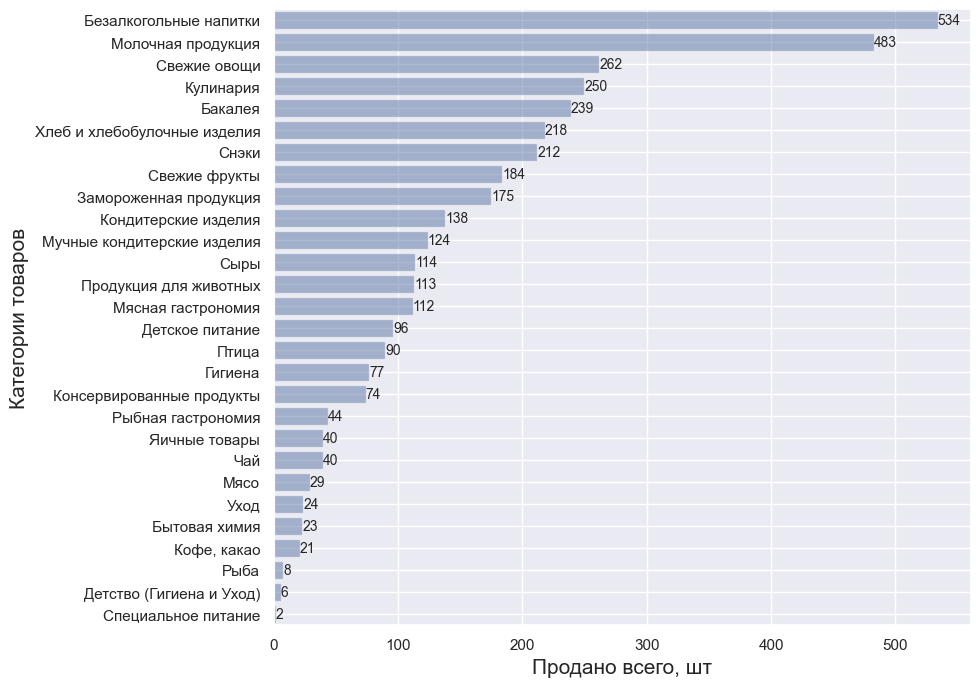

In [7]:
# Построение графика barchart
ax = sns.barplot(data=task_1_df, x='total_cnt', y='level1', orient='y', alpha = 0.5)

ax.set_xlabel('Продано всего, шт', fontsize = 15)
ax.set_ylabel('Категории товаров', fontsize = 15)
ax.bar_label(ax.containers[0], fontsize=10)
ax.grid(visible='major');

### Самая ходовая товарная группа "Безалкогольные напитки"

## 2. Распределение продаж по подкатегориям

### Оцените распределение количества проданных позиций в каждой товарной категории (level1) по подкатегориям (level2). Проиллюстрируйте свой результат расчетной таблицей.

In [8]:
merge_df.groupby(['level1','level2'])['quantity'].agg('sum')\
    .reset_index()\
    .rename(columns={'quantity':'total_cnt'})\
    .sort_values(['level1', 'total_cnt'], ascending=[True,False])
    
# Если нужно представить результат в виде сводной таблицы
# merge_df.groupby(['level1','level2'])['quantity'].agg('sum')\
#     .reset_index()\
#     .rename(columns={'quantity':'total_cnt'})\
#     .pivot(columns='level1', index='level2', values='total_cnt')\
#     .replace(np.nan, '-')

,level1,level2,total_cnt
10,Бакалея,Сухие блюда быстрого приготовления,38
3,Бакалея,"Крупы, бобовые",30
1,Бакалея,Зерновые для завтраков,24
4,Бакалея,Макаронные изделия,24
9,Бакалея,Соусы,24
...,...,...,...
95,Хлеб и хлебобулочные изделия,Хлеб и хлебобулочные изделия,218
98,Чай,Черный чай,26
96,Чай,Зеленый чай,7
97,Чай,Чайные напитки,7


## 3. Найти средний чек в заданную дату

### Какой средний чек был 13.01.2022?

In [9]:
# добавить поле с датой для последующей фильтрации
df_orders['date'] = pd.to_datetime(df_orders['accepted_at']).dt.strftime('%Y-%m-%d')
# посчитать стоимость позиции в чеке в зависимости от числа проданных товаров
df_orders['order_total_sum'] = df_orders['quantity'] * df_orders['price']

# расчет среднего значения чека
df_orders.loc[df_orders['date']=='2022-01-13']\
    .groupby('order_id')\
    ['order_total_sum'].agg('sum')\
    .mean()\
    .round(2)

np.float64(915.64)

## 4. Доля промо в заданной категории

Когда товар продается по промо-акции, его базовая цена не совпадает с фактической ценой.

Вам необходимо:

*    Посчитать, какую долю от общих продаж категории Сыры занимают промо (в штуках)
*    Построить пайчарт, который это проиллюстрирует. На графике должны быть видны группы, соответствующие доли и понятные подписи к ним.

### Расчеты

In [10]:
# расчет в денежном эквиваленте
cheese_discount_sum_df = merge_df.loc[merge_df['level1']=='Сыры'].groupby('discont')['total_sel_price'].agg('sum').reset_index()

# расчет в количестве продаж (каждая строчка df - это одна продажа)
cheese_discount_cnt_df = merge_df.loc[merge_df['level1']=='Сыры'].groupby('discont')['total_sel_price'].agg('count').reset_index()

### Построение pie chart

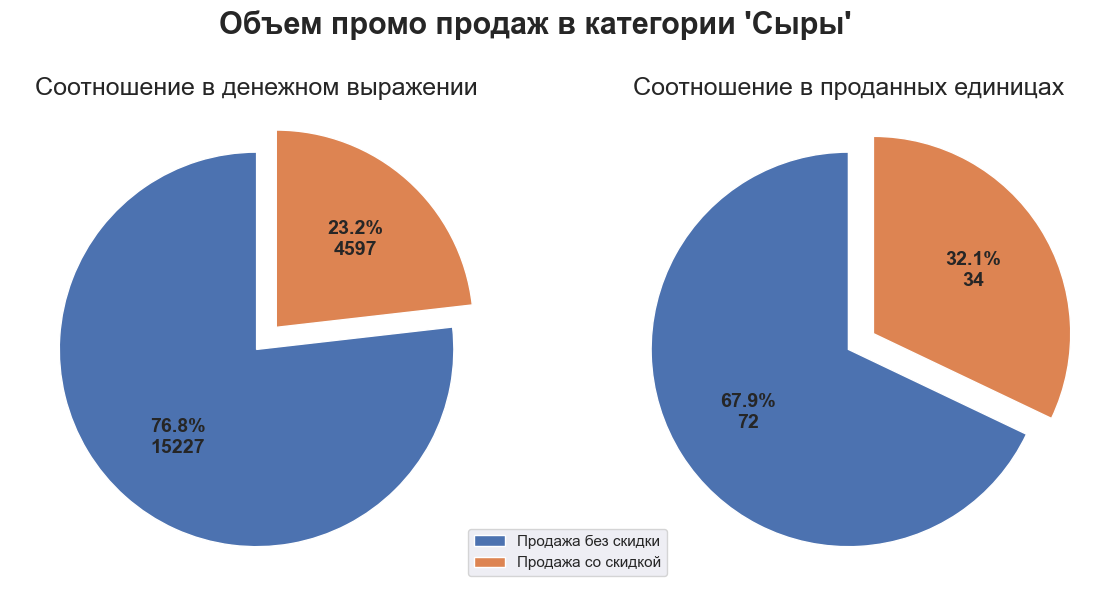

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# функция для autopct, вывода % и самого значения
def func(pct, allvalues):
    absolute = round(pct / 100.*allvalues.sum())
    return "{:.1f}%\n{:d}".format(pct, absolute)

ax1.pie(cheese_discount_sum_df['total_sel_price'], 
        explode=[0, 0.15], 
        startangle=90, 
        autopct=lambda pct: func(pct, cheese_discount_sum_df['total_sel_price']), 
        textprops=dict(fontsize=14, fontweight='bold'))

ax1.set_title('Соотношение в денежном выражении', fontsize=18)


ax2.pie(cheese_discount_cnt_df['total_sel_price'], 
        explode=[0, 0.15],
        startangle=90,
        autopct=lambda pct: func(pct, cheese_discount_cnt_df['total_sel_price']),
        textprops=dict(fontsize=14, fontweight='bold'))

ax2.set_title('Соотношение в проданных единицах', fontsize=18)


fig.suptitle("Объем промо продаж в категории 'Сыры'", fontsize=22, fontweight='bold')
fig.legend(['Продажа без скидки', "Продажа со скидкой"], bbox_to_anchor=(0.6, 0.25));

## 5. Посчитать маржу по категориям

Нужно посчитать маржу:

*    В рублях
*    В %

Сделать это нужно по всем категориям level1 и отобразить с помощью 2 горизонтальных барчартов. Все подписи должны быть читаемыми и понятными.

### Расчеты

In [12]:
marginality = merge_df.groupby('level1')[['total_sel_price', 'total_cost_price']].agg('sum').reset_index()
marginality['margin_abs'] = marginality['total_sel_price'] -  marginality['total_cost_price']
marginality['margin_ratio'] = ((marginality['total_sel_price'] -  marginality['total_cost_price'])*100.0 / marginality['total_sel_price']).round(1)
marginality.sort_values('margin_abs', ascending=False)

,level1,total_sel_price,total_cost_price,margin_abs,margin_ratio
1,Безалкогольные напитки,46107,25734,20373,44.2
10,Кулинария,40840,22388,18452,45.2
6,Замороженная продукция,27714,14615,13099,47.3
11,Молочная продукция,37582,25089,12493,33.2
13,Мясная гастрономия,24150,13920,10230,42.4
21,Снэки,22477,12895,9582,42.6
19,Свежие овощи,33222,24216,9006,27.1
0,Бакалея,21766,13589,8177,37.6
20,Свежие фрукты,27009,19130,7879,29.2
23,Сыры,19824,12350,7474,37.7


### Построение barchart

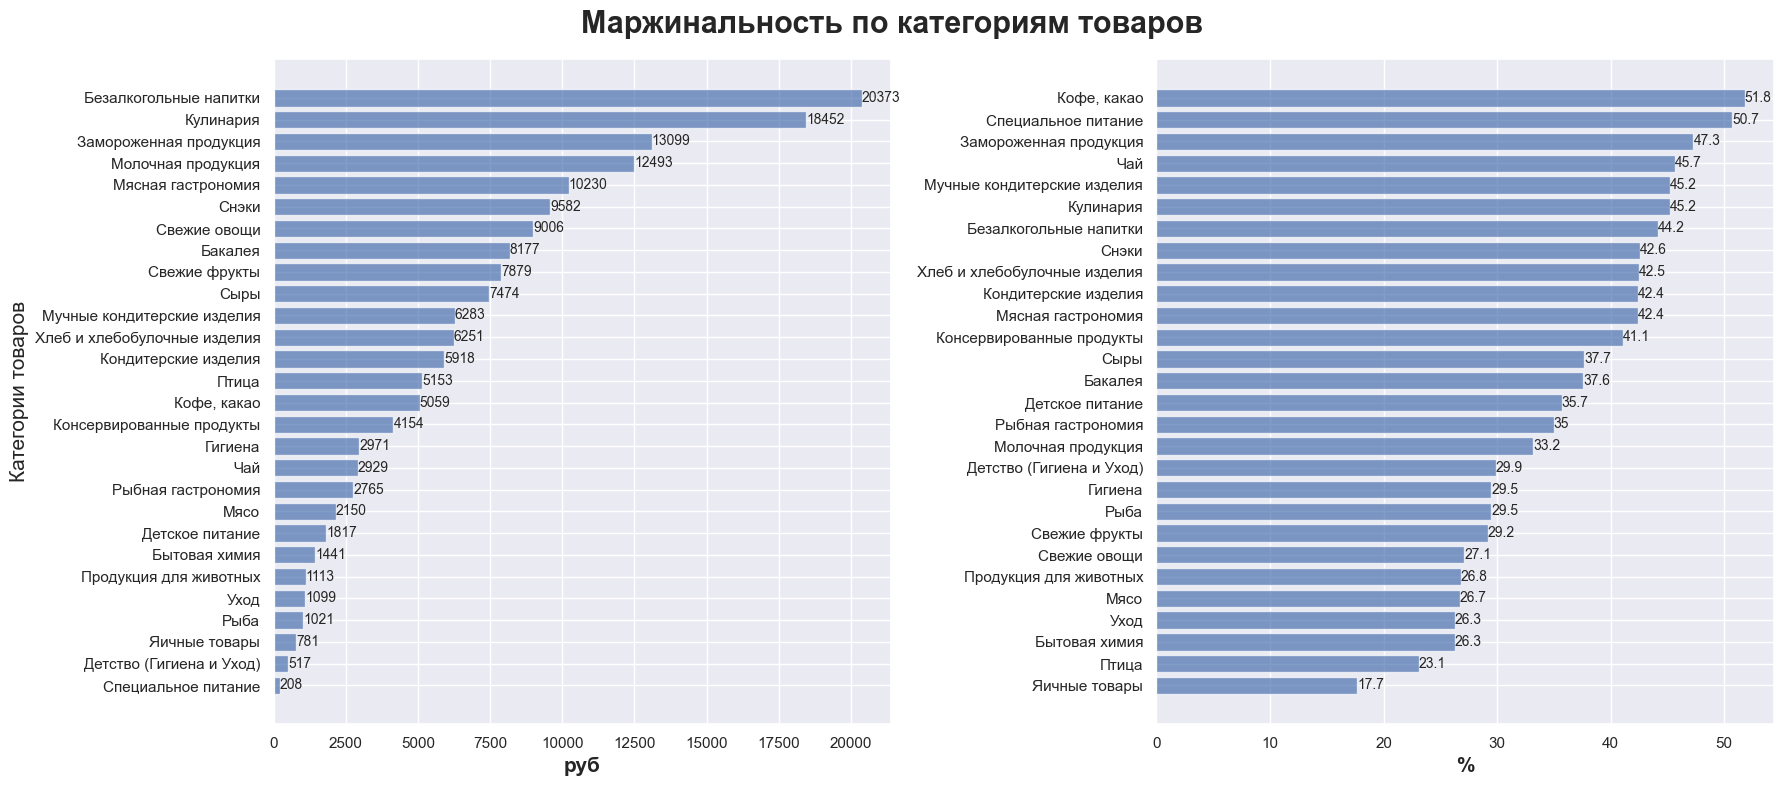

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
#plt.subplots_adjust(left=0.15, right=0.95, wspace=0.4)

ax1.barh(marginality.sort_values('margin_abs', ascending=True)['level1'], marginality.sort_values('margin_abs', ascending=True)['margin_abs'], alpha = 0.7)
ax1.set_xlabel('руб', fontsize = 15, fontweight='bold')
ax1.set_ylabel('Категории товаров', fontsize = 15)
ax1.bar_label(ax1.containers[0], fontsize=10)
ax1.grid(visible='major')

ax2.barh(marginality.sort_values('margin_ratio', ascending=True)['level1'], marginality.sort_values('margin_ratio', ascending=True)['margin_ratio'], alpha = 0.7)
ax2.set_xlabel('%', fontsize = 15, fontweight='bold')
ax2.bar_label(ax2.containers[0], fontsize=10)
ax2.grid(visible='major')

fig.suptitle("Маржинальность по категориям товаров", fontsize=22, fontweight='bold')
plt.tight_layout();

## 6. ABC анализ

*    Сделайте ABC-анализ продаж по количеству
*    Сделайте ABC-анализ по сумме продаж
*    Сделайте новый столбец, в котором будет итоговая группа на основании двух анализов. Например: A C.

#### Важно: предлагаем провести ABC-анализ по подкатегориям, а не по отдельным товарам. Имеющихся у нас данных за небольшой период недостаточно для качественного анализа на уровне товаров. К тому же, количество товаров слишком велико, что может также исказить результаты. А ABC-анализ по подкатегориям даст более адекватную и интерпретируемую картину.

In [ ]:
# рассчет сумм
abc_df = merge_df.groupby(merge_df['level2'])[['quantity', 'total_sel_price']].agg('sum').reset_index().rename(columns={'quantity':'total_quantity', 'total_sel_price':'total_sell'})

,level2,total_quantity,total_sell
0,Готовые блюда,248,40356
1,Напитки,252,24123
2,Мясо птицы охлажденное,90,22349
3,"Тепличные овощи, грибы",105,18329
4,Снэки соленые,180,17293


ABC анализ по выручке

In [ ]:
abc_df.sort_values('total_sell', ascending=False, inplace=True, ignore_index=True)
abc_df['sell_ratio'] = (abc_df['total_sell']*100.0 / abc_df['total_sell'].sum()).round(3)
abc_df['sell_ratio_cum_sum'] = abc_df['sell_ratio'].cumsum()
abc_df['sell_group'] = np.where(abc_df['sell_ratio_cum_sum'] < 80, 'A', np.where(abc_df['sell_ratio_cum_sum'] < 95, 'B', 'C'))


ABC анализ по числу проданных едениц товара

In [ ]:
abc_df.sort_values('total_quantity', ascending=False, inplace=True, ignore_index=True)
abc_df['quant_ratio'] = (abc_df['total_quantity']*100.0 / abc_df['total_quantity'].sum()).round(3)
abc_df['quant_ratio_cum_sum'] = abc_df['quant_ratio'].cumsum()
abc_df['quant_group'] = np.where(abc_df['quant_ratio_cum_sum'] < 80, 'A', np.where(abc_df['quant_ratio_cum_sum'] < 95, 'B', 'C'))

In [73]:
# Обеденить группы
for i, row in abc_df.iterrows():
    abc_df.loc[i, 'ABC_sell_quant_group'] = f"{row['sell_group']} {row['quant_group']}"

# добавить группу к исходному DF
merge_df = pd.merge(
    merge_df, 
    abc_df[['level2', 'ABC_sell_quant_group']], 
    on='level2'
)
merge_df

,order_id,accepted_at,product_id,quantity,regular_price,price,cost_price,level1,level2,name,date,total_sel_price,total_cost_price,discont,ABC_sell_quant_group
0,1517514900,2022-01-13 16:48:19,17122,1,169,169,74,Рыбная гастрономия,Нерыбные продукты моря,Крабовые палочки Меридиан,2022-01-13,169,74,False,B B
1,1517430051,2022-01-13 16:46:53,17122,1,169,169,74,Рыбная гастрономия,Нерыбные продукты моря,Крабовые палочки Меридиан,2022-01-13,169,74,False,B B
2,1517578174,2022-01-13 18:12:30,17122,1,169,169,74,Рыбная гастрономия,Нерыбные продукты моря,Крабовые палочки Меридиан,2022-01-13,169,74,False,B B
3,1517466327,2022-01-13 15:11:12,22199,1,219,219,130,Сыры,Мягкие сыры,Сыр Самокат,2022-01-13,219,130,False,A A
4,1517429157,2022-01-13 19:15:59,22199,1,219,219,130,Сыры,Мягкие сыры,Сыр Самокат,2022-01-13,219,130,False,A A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3013,1517405750,2022-01-13 19:29:44,79337,2,105,105,54,Замороженная продукция,Мороженое,Мороженое Магнат,2022-01-13,210,108,False,A A
3014,1517676281,2022-01-13 08:21:53,79337,1,105,105,54,Замороженная продукция,Мороженое,Мороженое Магнат,2022-01-13,105,54,False,A A
3015,1517545392,2022-01-13 13:16:21,11897,1,513,513,392,Продукция для животных,Товары для кошек,Корм Perfect Fit,2022-01-13,513,392,False,B A
3016,1517658904,2022-01-13 08:50:25,6392,2,79,79,45,Мучные кондитерские изделия,Хлебцы,Хлебцы Dr. Korner,2022-01-13,158,90,False,B B
